In [37]:
#Downloading and formatting the dataset

from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

end_date = dt.datetime.now()
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers = symbols_list, start = start_date, end = end_date)
df = df.stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

[*********************100%***********************]  503 of 503 completed

1 Failed download:
['LEN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-03-01 10:25:16.341557 -> 2025-02-27 10:25:16.341557)')


In [39]:
df['adj close'] = df['close'].copy()

In [41]:
#Computing the technical indicators

df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2 - (2 * np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open'])) ** 2)
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close = x, length = 20))

df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,1]) 
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length = 20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low = stock_data['low'],
                        close = stock_data['close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20)
    if macd is not None:
        return macd.iloc[:, 0].sub(macd.iloc[:, 0].mean()).div(macd.iloc[:, 0].std())
    else:
        return pd.Series([np.nan] * len(close), index=close.index)

df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6

In [42]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-03-01 A        48.966034   48.966034   49.173036   48.570841   48.570841   
           AAPL     32.469906   32.469906   32.553525   31.961224   32.028582   
           ABBV     44.592304   44.592304   44.663276   43.967742   44.116784   
           ABT      39.494366   39.494366   39.589659   39.147847   39.303780   
           ACGL     30.343172   30.343172   30.419244   30.080090   30.143484   
...                       ...         ...         ...         ...         ...   
2025-02-26 XYL     128.500000  128.500000  129.570007  128.199997  128.669998   
           YUM     151.500000  151.500000  155.179993  151.169998  154.899994   
           ZBH     104.919998  104.919998  107.580002  103.940002  106.800003   
           ZBRA    319.480011  319.480011  323.690002  312.929993  314.869995   
           ZTS     164.990005  164.990005  169.000000  164.880005  168.210007   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-03-01 A         2026600.0          0.000051        NaN       NaN   
           AAPL    145658400.0          0.000096        NaN       NaN   
           ABBV      7737400.0          0.000079        NaN       NaN   
           ABT       8886300.0          0.000054        NaN       NaN   
           ACGL       877800.0          0.000046        NaN       NaN   
...                        ...               ...        ...       ...   
2025-02-26 XYL       1280800.0          0.000056  57.140725  4.809566   
           YUM       2112000.0          0.000152  68.066806  4.844244   
           ZBH       1719400.0          0.000471  48.749677  4.585770   
           ZBRA       572200.0          0.000490  32.651778  5.678659   
           ZTS       2609700.0          0.000160  47.377816  5.049293   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2017-03-01 A            NaN       NaN       NaN       NaN      99.234564  
           AAPL         NaN       NaN       NaN       NaN    4729.514535  
           ABBV         NaN       NaN       NaN       NaN     345.028495  
           ABT          NaN       NaN       NaN       NaN     350.958782  
           ACGL         NaN       NaN       NaN       NaN      26.635236  
...                     ...       ...       ...       ...            ...  
2025-02-26 XYL     4.860492  4.911417  0.665978  0.908614     164.582800  
           YUM     4.964738  5.085232  1.730409  3.559832     319.968000  
           ZBH     4.658071  4.730372 -0.343915 -0.251976     180.399445  
           ZBRA    5.859379  6.040099  0.706738 -2.843782     182.806462  
           ZTS     5.126665  5.204038  1.101626 -0.825490     430.574417  

[990083 rows x 14 columns]

In [43]:
#Aggregate to monthly level and filter top 150 most liquid stocks for each month
'''This is done to reduce training time for the ML model and experiment with strats'''
#This computes the average monthly dollar volume to give a sense of liquidity

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume',
                                                          'open','high','low','close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack().to_frame('dollar_volume'),
          df.unstack()[last_cols].resample('M').last().stack('ticker')], axis = 1).dropna()

In [44]:
#Calculating the 5 year rolling average rolling average for each stock
#and use this value to filter out top 150 most liquid stocks for each month

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending = False)

#We are finding the 150 most liquid stocks then dropping the columns that we dont need
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis = 1)

In [45]:
'''Removing the timezones from the dataframe data as they are not necessary'''
#Remove the time zone from the 'date' index of data
data.index = data.index.set_levels([data.index.levels[0].tz_localize(None), data.index.levels[1]])

#Convert the 'date' index to only the date part (remove time part)
data.index = data.index.set_levels([data.index.levels[0].date, data.index.levels[1]])

In [46]:
#Calculating monthly returns for different time horizons as features
'''To capture time series dynamics that reflect, for instance, momentum patterns, we
compute historical returns using the method .pct_change(lag), that is, returns over
various monthly periods as identified by lags'''

def calculate_returns(df):

    outlier_cutoff = 0.005 #only the 99.005 percentile is considered and values above this percentile are assigned the same value as the cutoff
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),
                                                    upper = x.quantile(1 - outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df
    
data = data.groupby(level = 1, group_keys = False).apply(calculate_returns).dropna()

In [47]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-03-31 AAPL     45.501312          0.000033  63.873619  3.736433   
           ABBV     61.728622          0.000053  50.140513  4.100109   
           ABT      72.026184          0.000061  61.581395  4.250267   
           ACN     161.513794          0.000059  74.400460  4.988416   
           ADBE    266.489990          0.000040  58.172459  5.539514   
...                       ...               ...        ...       ...   
2025-02-28 MRNA     33.580002          0.000918  43.963006  3.413427   
           UBER     75.870003          0.000101  55.745779  4.168680   
           CRWD    394.559998          0.001050  49.154500  5.929304   
           PLTR     89.309998          0.001045  48.403042  4.347176   
           ABNB    144.029999          0.000191  54.406497  4.809719   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-03-31 AAPL    3.806203  3.875972 -1.108374  0.183278   0.097026   
           ABBV    4.127139  4.154170 -1.130016 -0.262247   0.017037   
           ABT     4.275061  4.299854 -0.839710  0.484598   0.029889   
           ACN     5.031594  5.074772 -0.910586  0.489607   0.090718   
           ADBE    5.567821  5.596127 -0.958711  0.117767   0.015200   
...                     ...       ...       ...       ...        ...   
2025-02-28 MRNA    3.570609  3.727792 -0.713868 -0.165085  -0.148148   
           UBER    4.321885  4.475090  2.220552  1.777530   0.134929   
           CRWD    6.037766  6.146228  2.558831  0.594111  -0.008818   
           PLTR    4.629963  4.912750  5.725569  1.888103   0.082677   
           ABNB    4.951955  5.094192 -0.242686  0.944302   0.098041   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-03-31 AAPL     0.070582   0.065415  -0.027103   0.004128    0.011669  
           ABBV     0.001866  -0.039943  -0.022614  -0.011759   -0.009745  
           ABT      0.046599   0.035504   0.015896   0.032034    0.025852  
           ACN      0.070671   0.076723   0.007146   0.009190    0.012982  
           ADBE     0.036985   0.056097  -0.002148   0.009932    0.017628  
...                      ...        ...        ...        ...         ...  
2025-02-28 MRNA    -0.101334  -0.079546  -0.129925  -0.137262   -0.080757  
           UBER     0.121513   0.017793   0.006149   0.018098   -0.003887  
           CRWD     0.073846   0.044780   0.060553   0.025820    0.016515  
           PLTR     0.086683   0.100109   0.189810   0.168554    0.111641  
           ABNB     0.046917   0.019032   0.034792  -0.000692   -0.007407  

[10360 rows x 14 columns]

In [48]:
'''Download FAMA-FRENCH factors and calculate rolling factor betas'''
#we are introducing the FAMA french data to estimate the exposure of assets to
#common risk factors with linear regression.
#five factors are market risk size, value, operating probability and investment
#these have been shown to empirically assess asset returns
#we can access historical returns using pandas-datareader and estimate historial 
#exposures using Rollingols model

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start = '2010')[0].drop('RF', axis = 1)

factor_data.index = factor_data.index.to_timestamp() #but this returns beginning of month data, which we have to fix to end of month

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'
#now we just combine this with the 1 month return from previous code

# '''We are adding timezones to factordata date as data has timezones'''
# #Check if 'factor_data' is timezone-aware
# if factor_data.index.tz is None:
#     # If it's not timezone-aware, localize it to UTC (or any timezone you prefer)
#     factor_data.index = factor_data.index.tz_localize('UTC')
# else:
#     # If it's already timezone-aware, ensure it's in the same timezone (UTC)
#     factor_data.index = factor_data.index.tz_convert('UTC')
# '''end of bug fix'''

factor_data = factor_data.join(data['return_1m']).sort_index()

In [49]:
'''Filter out stocks with less than 10 months of data'''
#we do this because we are going to use rolling window for the regression of 24mnths
#stocks without enough data can break our functions

observations = factor_data.groupby(level = 1).size()
valid_stocks = observations[observations >= 10] #more than 10 months data

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

In [50]:
'''Calculating the rolling factor betas'''

betas = (factor_data.groupby(level = 1,
                    group_keys = False)
        .apply(lambda x: RollingOLS(endog = x['return_1m'],
                                    exog = sm.add_constant(x.drop('return_1m', axis = 1)),
                                    window = min(24, x.shape[0]), #if less than 24 months data, still calculate ols
                                    min_nobs = len(x.columns)+1)
        .fit(params_only = True)
        .params
        .drop('const', axis = 1)))

In [51]:
'''Joining the betas to the features as well'''
#however we cannot blindly join betas to our dataset
#this is because we use the factor at the beginning of the month and return at the end of the month to compute betas.
#so at the end of the month, well be able to run the regression and have the betas but we will have them in the next month.
#so the betas of oct 31 will be known in nov 1
#so we shift the betas one month ahead before joining
#doing betas.shift() will simply shift betas forward by ticker, so XOM will get WMT's beta

data = data.join( betas.groupby('ticker').shift() )

#removing the NaN values in the FAMA-French columns
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data.loc[:, factors] = data.groupby('ticker', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data = data.drop('adj close', axis = 1)

In [52]:
'''Now we will start with the ML model as the data is complete'''
#We have the top 150 most liquid stocks at the end of each month.
#Our job is to build portfolios at the EOM and evaluate which stocks to put in.

'''We'll use a K-means clustering alg to group similar assets based on their features'''
#Split the stocks into four diff groups (optimal number of clusters as said by a quant)

"We'll use a K-means clustering alg to group similar assets based on their features"

In [53]:
from sklearn.cluster import KMeans

#Now we'll assign a cluster to each stock
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4, #4 clusters: 0,1,2,3
                           random_state = 0,  #clustering works with random seed
                           init = 'random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys = False).apply(get_clusters)

In [13]:
'''Visualizing the clustering'''
#Since we didnt normalize the RSI before, we can use this for visualization
#We cannot visualize all the features in even a 3 dimensional space

def plot_clusters(data):

    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]

    #5th index (6th column) is the ATR in the dataframe
    #1st index (2nd column) is the RSI in the dataframe
    #Plotting ATR against RSI
    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color = 'red', label = 'cluster_0')
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color = 'green', label = 'cluster_1')
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color = 'blue', label = 'cluster_2')
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color = 'black', label = 'cluster_3')

    plt.legend()
    plt.show()

In [ ]:
#actually plotting

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level = 0)
    plt.title(f'Date {i}')
    plot_clusters(g)

#an observation i made was that the clusters are grouped based on RSI values
#clusters more or less are grouped as >60, 50-60, 40-50 and <40
#however since K-means centroids are random, the clusters are also a bit random

In [54]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18)) #checked the k means docs for this. 18 represents the number of columns of data

initial_centroids[:, 1] = target_rsi_values #rsi value column

In [55]:
'''Now we are going to apply the newfound knowledge about initial centroids to the K-means clustering alg'''
#We will drop the original clusters

data = data.drop('cluster', axis = 1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4, #4 clusters: 0,1,2,3
                           random_state = 0,  #clustering works with initial centroids
                           init = initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys = False).apply(get_clusters)

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level = 0)
    plt.title(f'Date {i}')
    plot_clusters(g)

In [56]:
'''At the beginnng of each new month, select stocks based on cluster and form'''
'''a portfolio based on efficient frointier max sharpe ratio optimization'''
#momentum is persistent, and our idea would be that stocks clustered around 70 rsi centroid should
#continue to outperform in the following month, So we would select the stocks of cluster 3

filtered_df = data[data['cluster'] == 3].copy()

filtered_df = filtered_df.reset_index(level = 1)
filtered_df.index = filtered_df.index + pd.DateOffset(1) #moving each day with one so we go from end of month to beginning of next month
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level = 0).index.tolist()

In [57]:
'''DEFINE PORTFOLIO OPTIMIZATION FUNCTION'''
#we will use the PyPortfolioOpt package and EfficientFrontier to maximize the sharpe ratio
#to optimize the weights of a given portfolio, we would need to supply last one year prices to the function
#apply single stock weight bounds constraint for diversification (minimum half of equally weight and maximum 10% of portfolio)

'DEFINE PORTFOLIO OPTIMIZATION FUNCTION'

In [58]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

#the lower bound is here because if i just put in 0, the porfolio might be designed such that:
#1 stock has a weight of 1 and the others have a weight of 0

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices = prices,
                                                      frequency = 252) #1 yr of trading data
    cov = risk_models.sample_cov(prices = prices,
                                 frequency = 252)
    ef = EfficientFrontier(expected_returns = returns,
                           cov_matrix = cov,
                           weight_bounds = (lower_bound, .1),
                           solver = 'SCS')
    weights = ef.max_sharpe()

    return ef.clean_weights()

In [59]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers = stocks,
                     start = data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end = data.index.get_level_values('date').unique()[-1]) #past year of data collected

[*********************100%***********************]  154 of 154 completed


In [63]:
new_df.rename(columns = {'Close':'Adj Close'}, inplace = True)
new_df

Price        Adj Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2018-04-02   39.328274   67.086182         NaN   51.510929  133.377884   
2018-04-03   39.731754   66.448013         NaN   52.209995  134.107925   
2018-04-04   40.491508   68.171768         NaN   52.617065  135.171463   
2018-04-05   40.772293   67.636292         NaN   52.971027  136.613586   
2018-04-06   39.729397   65.853867         NaN   50.944572  132.837051   
...                ...         ...         ...         ...         ...   
2025-02-21  245.550003  202.080002  146.070007  134.919998  364.260010   
2025-02-24  247.100006  204.080002  144.820007  134.949997  363.910004   
2025-02-25  247.039993  204.139999  141.550003  135.820007  362.950012   
2025-02-26  240.360001  203.009995  144.029999  135.960007  358.350006   
2025-02-27  241.559296  205.035004  142.942505  136.195007  359.842499   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2018-04-02  212.279999   78.192711   98.329765  122.750000  242.690002  ...   
2018-04-03  215.929993   78.871132   98.971970  124.839996  243.619995  ...   
2018-04-04  225.050003   80.386528  101.297859  127.500000  248.929993  ...   
2018-04-05  223.539993   80.122208  101.983482  128.020004  255.350006  ...   
2018-04-06  218.610001   77.805077   98.676888  125.750000  245.229996  ...   
...                ...         ...         ...         ...         ...  ...   
2025-02-21  444.320007  238.910004  310.760010  285.000000  190.429993  ...   
2025-02-24  444.420013  236.990005  312.200012  285.260010  190.720001  ...   
2025-02-25  443.410004  235.300003  313.369995  283.720001  186.619995  ...   
2025-02-26  441.500000  233.729996  311.380005  285.670013  191.210007  ...   
2025-02-27  441.820007  229.389999  312.670013  288.470001  191.220001  ...   

Price        Volume                                                            \
Ticker          VLO     VRTX        VZ       WBA     WDAY       WDC       WFC   
Date                                                                            
2018-04-02  2788500  1804500  16511200   7805300  1091800   4504418  23359800   
2018-04-03  2930600  1542300  14841300  10657200  1159200   3092645  16646400   
2018-04-04  3659600  1832000  12376400   8451500  1863500   3062877  15952700   
2018-04-05  3766300  1352800  13201300   6018500  1780500   3069889  16488800   
2018-04-06  3432000  1446300  16071600   5110900  1299500   4882796  22943800   
...             ...      ...       ...       ...      ...       ...       ...   
2025-02-21  2938900  1444000  25465100  24347700  2415400  11982940  18205400   
2025-02-24  2920600  1245400  27560600  31360900  3836100  18354400  12989700   
2025-02-25  2767400  1199200  24356900  23000200  4828400  11679700  15683000   
2025-02-26  4531700   823400  18624100  20536400  6230200   8546700  13466000   
2025-02-27   632174   259419   6362454   8831695   971843   2088234   4343855   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2018-04-02  57386700  2561200  17891100  
2018-04-03  29086500  2018900  15999200  
2018-04-04  19609800  2022200  13122200  
2018-04-05  19142700  1619600  14200000  
2018-04-06  19050000  2809600  14299600  
...              ...      ...       ...  
2025-02-21  35014800  2962200  14710000  
2025-02-24  29755900  2160600  13153500  
2025-02-25  29331200  2079800  14497000  
2025-02-26  19045600  2241800  10444100  
2025-02-27   6112440   677115   5118892  

[1738 rows x 770 columns]

In [60]:
#Calculate daily returns for each stock whcih could land up in the portfolio
#Loop over each month start, select stocks for the month and calculate weights for the nextmonth
#if max sharpe ratio optimization fails for a monnth, apply equally weighted weights
#calculate each day portfolio return

In [64]:
retruns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()


for start_date in fixed_dates.keys():

    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date] #stocks for each month which will form the portfolio

    optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

    #weights = optimize_weights(prices = optimization_df,
    #                       lower_bound = round(1/(len(optimization_df.columns*2)),3)) #half of the weight of an equally weighted portfolio

In [65]:
optimization_start_date = (pd.to_datetime( min(fixed_dates.keys()) ) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
optimization_end_date = (pd.to_datetime( max(fixed_dates.keys()) ) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

In [66]:
#now creating an optimization dataframe to calculate the weights of the stocks in the portfolio

optimization_df = new_df['Adj Close'][optimization_start_date:optimization_end_date][fixed_dates[dates[-1].strftime('%Y-%m-%d')]] #latest date (1 day more than optimization end date) that is in the dict fixed_dates

In [67]:
weights = optimize_weights(prices = optimization_df,
                           lower_bound = round(1/(len(optimization_df.columns*2)),3)) #half of the weight of an equally weighted portfolio

weights = pd.DataFrame(weights, index = pd.Series(0))

In [68]:
#implementing the weights back into the original loop:

retruns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()


for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = fixed_dates[start_date] #stocks for each month which will form the portfolio

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df['Adj Close'][optimization_start_date:optimization_end_date][cols]
        success = False

        try:
            weights = optimize_weights(prices = optimization_df,
                                lower_bound = round(1/(len(optimization_df.columns*2)),3)) #half of the weight of an equally weighted portfolio

            weights = pd.DataFrame(weights, index = pd.Series(0))

            success = True
        except:
            print(f"Max sharpe optimization failed for {start_date}, Continuing with equal weights")

        #if the max sharpe optimization fails, we just use an equally weighted portfolio
        if not success:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                index=optimization_df.columns.tolist(),
                                columns=pd.Series(0)).T

        temp_df = retruns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level = 0)\
                        .merge( weights.stack().to_frame('weight').reset_index(level = 0, drop = True),
                        left_index = True,
                        right_index = True )\
                        .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        temp_df = temp_df.groupby(level = 0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis = 0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

Max sharpe optimization failed for 2019-05-01, Continuing with equal weights
Max sharpe optimization failed for 2019-06-01, Continuing with equal weights
Max sharpe optimization failed for 2019-07-01, Continuing with equal weights
Max sharpe optimization failed for 2019-10-01, Continuing with equal weights
Max sharpe optimization failed for 2019-12-01, Continuing with equal weights
Max sharpe optimization failed for 2020-01-01, Continuing with equal weights
Max sharpe optimization failed for 2020-03-01, Continuing with equal weights
Max sharpe optimization failed for 2020-04-01, Continuing with equal weights
Max sharpe optimization failed for 2020-06-01, Continuing with equal weights
Max sharpe optimization failed for 2020-07-01, Continuing with equal weights
Max sharpe optimization failed for 2020-12-01, Continuing with equal weights
Max sharpe optimization failed for 2021-02-01, Continuing with equal weights
Max sharpe optimization failed for 2021-04-01, Continuing with equal weights

<Axes: xlabel='date'>

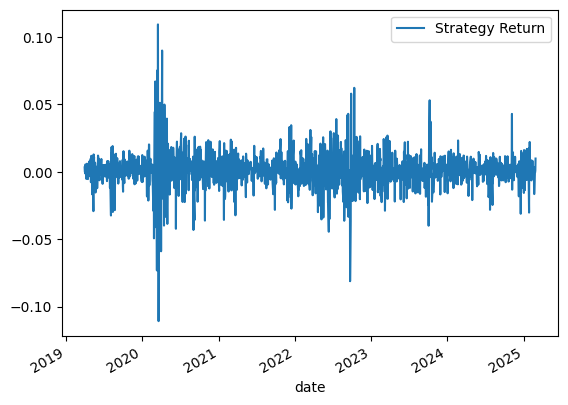

In [69]:
portfolio_df.plot()

In [71]:
'''Visualize portfolio returns and compare to beta/S&P500 returns'''
#first we download the SPY ETF data, then build an object that calculates the log retuns of the SPY

end_date = dt.datetime.now()
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

spy = yf.download(tickers = 'SPY',
                  start = start_date,
                  end = end_date)

spy.rename(columns = {'Close':'Adj Close'}, inplace = True)

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold', 'Date': 'date'}, axis = 1)
spy_ret.columns = ['SPY Buy&Hold'] #to make consistent with the portfolio_df

[*********************100%***********************]  1 of 1 completed


In [72]:
#Now, we merge the portfolio returns into the spy returns

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

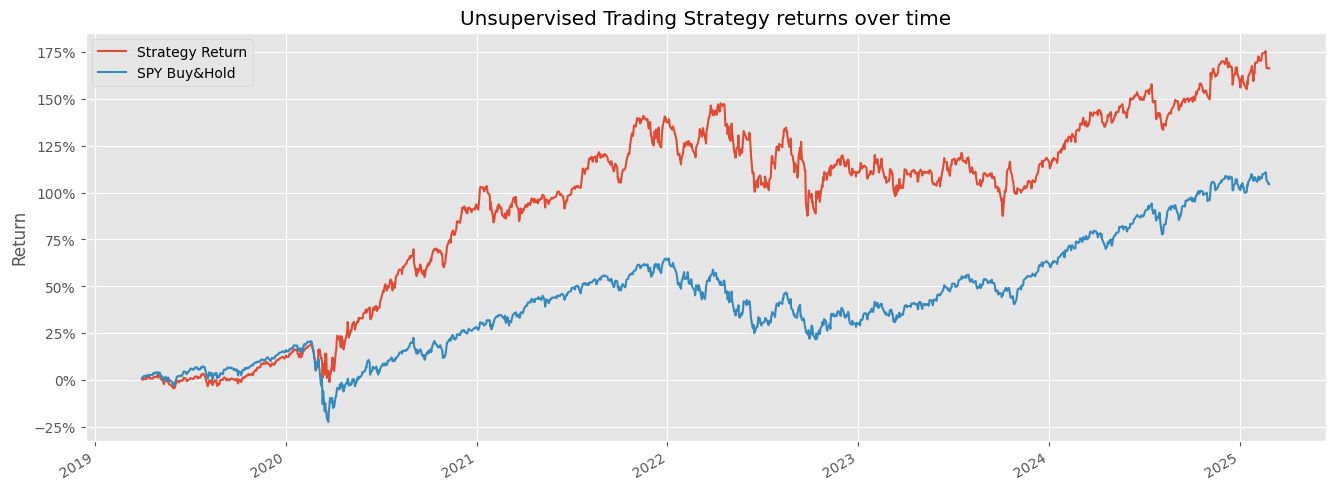

In [73]:
#comparing our alpha to our beta
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumilative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1
portfolio_cumilative_return.plot(figsize=(16,6))

plt.title('Unsupervised Trading Strategy returns over time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')

plt.show()

In [29]:
'''FINAL CONCLUSIONS'''
# 1) Selected the top 150 most liquid stocks with their dollar volume
# 2) Calculated 18 different features for each stock
# 3) Applied a K-Means clustering algorithm to assign clusters for every stock
# 4) Supplied our custom centroid with a custom array
# 5) Optimized the portfolio for each month to have the max sharpe portfolio weight

'FINAL CONCLUSIONS'